In [3]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp
import jax

jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

In [4]:
data = qml.data.load("qchem", molname="HeH+", basis="STO-3G", bondlength=1.78)[0]
H_obj = data.tapered_hamiltonian
H_obj = qml.Hamiltonian(jnp.array(H_obj.coeffs), H_obj.ops)
E_exact = data.fci_energy

In [5]:
energy_jax = np.zeros((100, 100))
energy_generator = np.zeros((100, 100))
energy_ps = np.zeros((2, 100, 100))
for i in range(100):
    dat = np.load(f"data/VQE_Maryland__HeH_jax_{i}.npz", allow_pickle=True)
    energy_jax[i] = dat["energy"]
    dat = np.load(f"data/VQE__HeH+-1.78_atol-1_{i}.npz", allow_pickle=True)
    energy_generator[i] = dat["energy"]
    dat = np.load(f"data/VQE_Maryland__HeH+-1.78_ps-split-8_{i}.npz", allow_pickle=True)
    energy_ps[0, i] = dat["energy"]
    dat = np.load(f"data/VQE_Maryland__HeH+-1.78_ps-split-20_{i}.npz", allow_pickle=True)
    energy_ps[1, i] = dat["energy"]
    # dat = np.load(f"data/VQE_Maryland_{i}_HeH+-0.775_legendre_ps_split-20.npz", allow_pickle=True)
    # energy_ps[2, i] = dat["energy"]
theta = dat["theta"]
energy_jax = energy_jax - E_exact
energy_generator = energy_generator - E_exact
energy_ps = energy_ps - E_exact

In [7]:
y_ps_var = np.std(energy_ps, axis=1)
y_ps_mean = np.mean(energy_ps, axis=1)
y_jax_var = np.std(energy_jax, axis=0)
y_jax_mean = np.mean(energy_jax, axis=0)
y_generator_var = np.std(energy_generator, axis=0)
y_generator_mean = np.mean(energy_generator, axis=0)

lower_percentile_ps = np.percentile(energy_ps, 5, axis=1)  # 5th percentile (90% below)
upper_percentile_ps = np.percentile(energy_ps, 95, axis=1)  # 95th percentile (90% above)

lower_percentile_jax = np.percentile(energy_jax, 5, axis=0)  # 5th percentile (90% below)
upper_percentile_jax = np.percentile(energy_jax, 95, axis=0)  # 95th percentile (90% above)

lower_percentile_generator = np.percentile(energy_generator, 5, axis=0)  # 5th percentile (90% below)
upper_percentile_generator = np.percentile(energy_generator, 95, axis=0)  # 95th percentile (90% above)

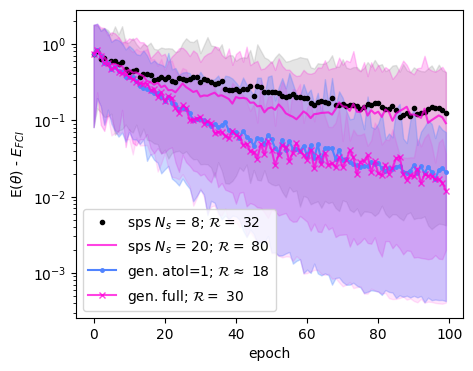

In [52]:
fig, ax = plt.subplots(figsize=(5,4))
color = ['#00b1ffff', '#D7A2F6', '#ff00d9bc', '#5184ffff', '#FFE096', '#FDC9DE', '#E1EBA8', '#C6FDD9']
x = np.arange(100)
n_splits = [8, 20]
Rs = [32, 80]

ax.plot(x, y_ps_mean[0], "o", markersize=3, label=f"sps $N_s$ = {n_splits[0]}; $\\mathcal{{R}} =$ {Rs[0]}", color="black")
ax.fill_between(x, lower_percentile_ps[0], upper_percentile_ps[0], alpha=0.2, color="gray")

ax.plot(x, y_ps_mean[1], "-", label=f"sps $N_s$ = {n_splits[1]}; $\\mathcal{{R}} =$ {Rs[1]}", color=color[2])
ax.fill_between(x, lower_percentile_ps[1], upper_percentile_ps[1], alpha=0.2, color=color[2])

ax.plot(x, y_generator_mean, ".-", markersize=5, label="gen. atol=1; $\\mathcal{R} \\approx$ 18", color=color[3])
ax.fill_between(x, lower_percentile_generator, upper_percentile_generator, alpha=0.3, color=color[3])

ax.plot(x, y_jax_mean, "x-", markersize=5, label="gen. full; $\\mathcal{R} =$ 30", color=color[2])
ax.fill_between(x, lower_percentile_jax, upper_percentile_jax, alpha=0.1, color=color[2])

ax.legend(loc=3)
ax.set_ylabel("E($\\theta$) - $E_{{FCI}}$")
ax.set_xlabel("epoch")

ax.set_yscale("log")